<a href="https://colab.research.google.com/github/ravinarayanaA/IEMOCAP-Multimodal-emotion-recognition/blob/main/emo_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Softmax
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
drive.mount('/content/drive')

import pandas as pd
base_path = "/content/drive/MyDrive/CSCI535/HW2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

# Load Dataset

I have used speakers to get the 10 folds and then loaded numpy arrays for all the modalities with thier id to reuse it later.

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/CSCI535/HW2/dataset.csv", index_col=0)
base_path = "/content/drive/MyDrive/CSCI535/HW2/"

In [ ]:
speakers = dataset["speakers"].unique()

In [ ]:
folds = []
base_path = "/content/drive/MyDrive/CSCI535/HW2"

Class weights are calculated to handle class imbalance

In [ ]:
class_weights = compute_sample_weights(tf.keras.utils.to_categorical(dataset.emotion_labels, 4))

In [ ]:
visual_data = {}
audio_data = {}
text_data = {}
labels = {}
count = 0
for id, row in dataset.iterrows():
    count += 1
    print(id, count)
    visual_data[id] = np.load(base_path + row["visual_features"])
    audio_data[id] = np.load(base_path + row["acoustic_features"])
    text_data[id] = np.load(base_path + row["lexical_features"])
    labels[id] = row["emotion_labels"]

This is just to save by pickling the data objects.

In [ ]:
# import pickle
# # pickle.dump([text_data, audio_data, visual_data, labels], open(base_path+"/pickled_data.pkl","wb"))
# text_data, audio_data, visual_data, labels = pickle.load(open(base_path+"/pickled_data.pkl","rb"))

# Helper functions

In [ ]:
# class classifierModelTrainer:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(labels), test_size=0.2,
                                                        random_state=2)
    X_train, X_val, y_train, y_val = train_test_split(np.array(data), np.array(labels), test_size=0.2,
                                                      random_state=3)
    X_train = np.resize(np.array(X_train), (X_train.shape[0], X_train[0].shape[0]))
    X_val = np.resize(np.array(X_val), (X_val.shape[0], X_train[0].shape[0]))

    y_train = tf.keras.utils.to_categorical(y_train)
    y_val = tf.keras.utils.to_categorical(y_val)
    y_test = tf.keras.utils.to_categorical(y_test)

    y_train = np.resize(np.array(y_train), (y_train.shape[0], 4))
    y_val = np.resize(np.array(y_val), (y_val.shape[0], 4))
    y_test = np.resize(np.array(y_test), (y_test.shape[0], 4))
    return X_train, X_val, X_test, y_train, y_val, y_test

def visualize_frequency(labels):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts)
    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()
    return

def compute_sample_weights(labels):
    y_integers = np.argmax(labels, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    return  class_weights

def print_average_score(precision_per_fold, recall_per_fold, loss_per_fold):
    
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Precision and Recall per fold')
    for i in range(0, len(precision_per_fold)):
        print('------------------------------------------------------------------------')
        if loss_per_fold is None:
            print(f'> Fold {i+1} - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1: {(2*recall_per_fold[i]*precision_per_fold[i])/(recall_per_fold[i]+precision_per_fold[i])}%')    
        else:
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]} - F1: {(2*recall_per_fold[i]*precision_per_fold[i])/(recall_per_fold[i]+precision_per_fold[i])}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Precision: {np.mean(precision_per_fold)} (+- {np.std(precision_per_fold)})')
    print(f'> Recall: {np.mean(recall_per_fold)} (+- {np.std(recall_per_fold)})')
    print(f'> F1: {(2*np.mean(recall_per_fold)*np.mean(precision_per_fold))/(np.mean(recall_per_fold)+np.mean(precision_per_fold))}')
    if loss_per_fold is not None:
        print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    e = range(1, len(metric)+1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name)
    plt.legend()
    plt.show()

# Text Modality



This is the generator for text data

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,class_weights, batch_size=32,
                 n_classes=4, shuffle=True,predict=False):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.class_weights = class_weights
        self.predict = predict

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs )/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y, sample_weights = self.__data_generation(list_IDs_temp)
        if self.predict:
            return X,y,None
        return X, y, sample_weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X.append(text_data[ID[0]])
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])

        return np.stack(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)

Text model initialization method

In [ ]:
def text_model_init(hidden_units, input_shape, loss, lr):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dense(4, activation="relu", name="Dense_2"))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.05))
    model.add(Softmax(name="Softmax_1"))
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    amsgrad=False,
                    name="Adam",
                )
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
    model.summary()
    return model

Modelling the text modal

I have added sample weights to handle imbalance of the classes. Grid search is run over all the folds. Also used early stopping for auto stopping of the training.

------------------------------------------------------------------------
Training for fold 1 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


38/38 - 1s - loss: 1.4864 - recall: 0.1661 - precision: 0.3953
Epoch 2/80
38/38 - 0s - loss: 1.1085 - recall: 0.3742 - precision: 0.6852
Epoch 3/80
38/38 - 0s - loss: 0.9884 - recall: 0.4671 - precision: 0.7435
Epoch 4/80
38/38 - 0s - loss: 0.9208 - recall: 0.4934 - precision: 0.7682
Epoch 5/80
38/38 - 0s - loss: 0.8648 - recall: 0.5255 - precision: 0.8078
Epoch 6/80
38/38 - 0s - loss: 0.8200 - recall: 0.5518 - precision: 0.8243
Epoch 7/80
38/38 - 0s - loss: 0.7886 - recall: 0.5913 - precision: 0.8255
Epoch 8/80
38/38 - 0s - loss: 0.7599 - recall: 0.6086 - precision: 0.8400
Epoch 9/80
38/38 - 0s - loss: 0.7262 - recall: 0.6275 - precision: 0.8661
Epoch 10/80
38/38 - 0s - loss: 0.7058 - recall: 0.6398 - precision: 0.8635
Epoch 11/80
38/38 - 0s - loss: 0.6873 - recall: 0.6579 - precision: 0.8639
Epoch 12/80
38/38 - 0s - loss: 0.6674 - recall: 0.6604 - precision: 0.8834
Epoch 13/80
38/38 - 0s - loss: 0.6520 - recall: 0.6801 - precision: 0.8845
Epoch 14/80
38/38 - 0s - loss: 0.6364 - recal

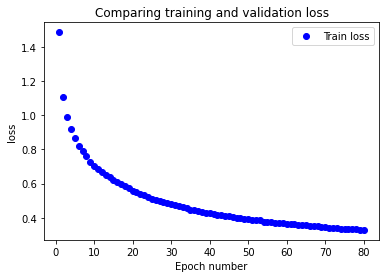

4/4 [==============================] - 0s 4ms/step - loss: 1.2848 - recall: 0.5254 - precision: 0.6526
Score for fold 1: loss of 1.2848055362701416; recall of 52.542370557785034%; precision of 65.26315808296204%
------------------------------------------------------------------------
Training for fold 2 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
______________________________________________________________

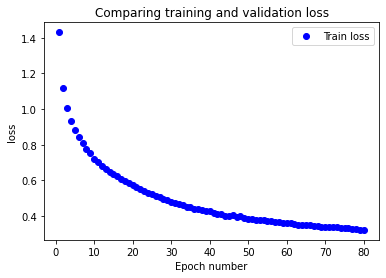

4/4 [==============================] - 0s 5ms/step - loss: 1.2034 - recall: 0.6019 - precision: 0.7143
Score for fold 2: loss of 1.2033801078796387; recall of 60.18518805503845%; precision of 71.42857313156128%
------------------------------------------------------------------------
Training for fold 3 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_______________________________________________________________

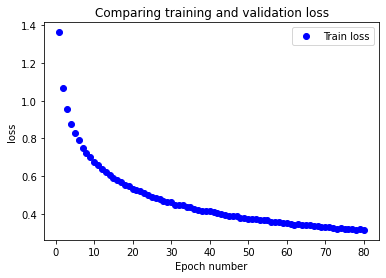

4/4 [==============================] - 0s 4ms/step - loss: 1.7182 - recall: 0.4571 - precision: 0.5217
Score for fold 3: loss of 1.718228816986084; recall of 45.71428596973419%; precision of 52.173912525177%
------------------------------------------------------------------------
Training for fold 4 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_________________________________________________________________


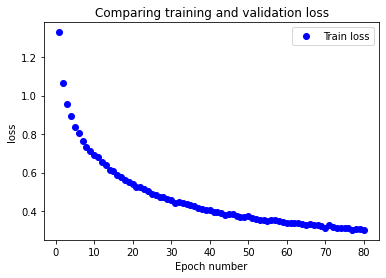

5/5 [==============================] - 0s 4ms/step - loss: 1.6140 - recall: 0.5000 - precision: 0.5797
Score for fold 4: loss of 1.6140120029449463; recall of 50.0%; precision of 57.971012592315674%
------------------------------------------------------------------------
Training for fold 5 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8

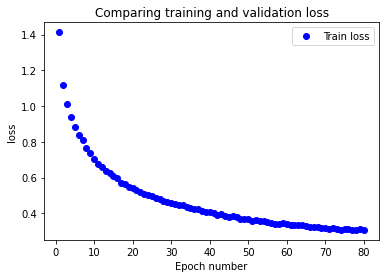

5/5 [==============================] - 0s 4ms/step - loss: 1.5686 - recall: 0.5188 - precision: 0.6058
Score for fold 5: loss of 1.568627119064331; recall of 51.875001192092896%; precision of 60.583943128585815%
------------------------------------------------------------------------
Training for fold 6 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
______________________________________________________________

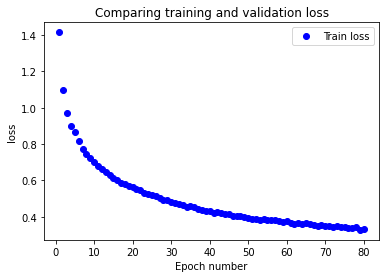

4/4 [==============================] - 0s 4ms/step - loss: 1.3116 - recall: 0.5537 - precision: 0.6505
Score for fold 6: loss of 1.311625599861145; recall of 55.37189841270447%; precision of 65.04854559898376%
------------------------------------------------------------------------
Training for fold 7 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
________________________________________________________________

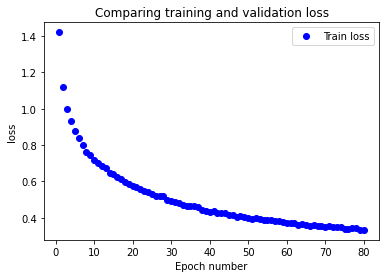

4/4 [==============================] - 0s 5ms/step - loss: 1.4339 - recall: 0.5591 - precision: 0.6339
Score for fold 7: loss of 1.4338730573654175; recall of 55.90550899505615%; precision of 63.39285969734192%
------------------------------------------------------------------------
Training for fold 8 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_______________________________________________________________

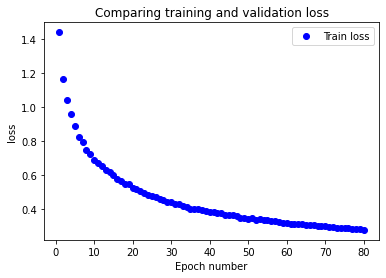

4/4 [==============================] - 0s 5ms/step - loss: 1.7246 - recall: 0.4444 - precision: 0.5600
Score for fold 8: loss of 1.7246052026748657; recall of 44.44444477558136%; precision of 56.00000023841858%
------------------------------------------------------------------------
Training for fold 9 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
_______________________________________________________________

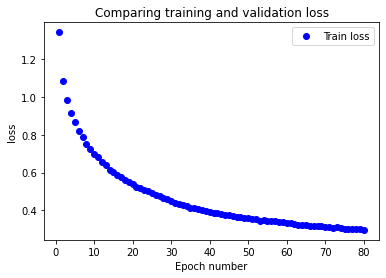

5/5 [==============================] - 0s 4ms/step - loss: 1.6370 - recall: 0.5034 - precision: 0.5906
Score for fold 9: loss of 1.6370261907577515; recall of 50.33556818962097%; precision of 59.05511975288391%
------------------------------------------------------------------------
Training for fold 10 ...
training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_2 (Dense)              (None, 4)                 3076      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
Softmax_1 (Softmax)          (None, 4)                 0         
Total params: 3,076
Trainable params: 3,076
Non-trainable params: 0
______________________________________________________________

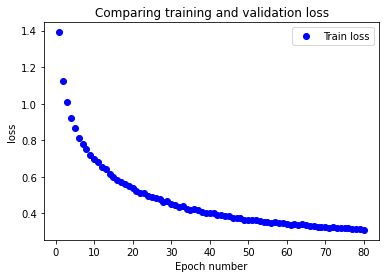

6/6 [==============================] - 0s 4ms/step - loss: 1.3329 - recall: 0.5123 - precision: 0.6484
Score for fold 10: loss of 1.332916021347046; recall of 51.234567165374756%; precision of 64.84375%
------------------------------------------------------------------------
Precision and Recall per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2848055362701416 - Precision: 52.542370557785034 - Recall: 65.26315808296204 - F1: 58.21596108996586%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2033801078796387 - Precision: 60.18518805503845 - Recall: 71.42857313156128 - F1: 65.32663556861833%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.718228816986084 - Precision: 45.71428596973419 - Recall: 52.173912525177 - F1: 48.73096438606599%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.6140120029449463 - Precis

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
param_grid = {
        "learn_rate" : [0.001],
        "batch_size" : [32],
        "epochs" : [80]
        }
grid = ParameterGrid(param_grid)
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1

for i, params in enumerate(grid):
    precision_per_fold, recall_per_fold, loss_per_fold = [], [], []
    for train, test in kfold.split(speakers):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        print("training for params: ", params)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(base_path+'/checkpoints_text/model_'+str(fold_no)+'.h5', 
                    monitor="loss", verbose=1, 
                    save_best_only=True, mode='min')
        
        train_data_ids = dataset[dataset['speakers'].isin(speakers[train])].lexical_features.reset_index()
        y_train_ids = dataset[dataset['speakers'].isin(speakers[train])].emotion_labels

        test_data = np.asarray([text_data[sample] for sample in dataset[dataset['speakers'].isin(speakers[test])].lexical_features.keys()])
        test_data = np.stack(test_data)
        labels_test = keras.utils.to_categorical(dataset[dataset['speakers'].isin(speakers[test])].emotion_labels.tolist(), 4)
        text_model = text_model_init(4, (768,), 'categorical_crossentropy', params["learn_rate"])
        training_generator = DataGenerator(train_data_ids, y_train_ids, class_weights, batch_size=params["batch_size"])
        results = text_model.fit_generator(training_generator, epochs=params["epochs"], verbose=2,callbacks=[early_stop])
    
        eval_metric(results, 'loss')
        text_model.save(base_path+'/checkpoints_text/model_'+str(fold_no)+'.h5')
        scores = text_model.evaluate(test_data, labels_test)
        print(f'Score for fold {fold_no}: {text_model.metrics_names[0]} of {scores[0]}; {text_model.metrics_names[1]} of {scores[1]*100}%; {text_model.metrics_names[2]} of {scores[2]*100}%')

        precision_per_fold.append(scores[1] * 100)
        recall_per_fold.append(scores[2] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    print_average_score(precision_per_fold, recall_per_fold, loss_per_fold)

# Visual Modality

Visual modality data generator. I have padded the data with zeros to make all arrays of size(716,2048)

In [ ]:
import numpy as np
import keras

class VisualDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,class_weights, batch_size=32,
                 n_classes=4, shuffle=True,predict=False):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.class_weights = class_weights
        self.predict = predict

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs )/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y, sample_weights = self.__data_generation(list_IDs_temp)
        if self.predict:
            return X,y,None
        return X, y, sample_weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            dist = 716 - len(visual_data[ID[0]])
            # Store sample
            # X.append(np.vstack((visual_data[ID[0]], np.zeros((716-visual_data[ID[0]].shape[0],2048)))))
            X.append(np.pad(visual_data[ID[0]], pad_width=[(0,dist), (0,0)], mode='constant'))
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])

        return np.array(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)

Here is the visual modal architecture

In [ ]:
def visual_model_init(hidden_units, input_shape, loss, lr):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    # model.add(LSTM(4))
    model.add(tf.keras.layers.Conv1D(8, 1, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv1D(2, 1, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.MaxPool1D(pool_size=64,strides=64))
    model.add((tf.keras.layers.Flatten()))

    model.add(Dense(128, kernel_initializer='uniform',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                # activity_regularizer=tf.keras.regularizers.l2(0.001), 
                activation="relu", name="Dense_1"))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(Dense(4, activation="softmax", kernel_regularizer=tf.keras.regularizers.l1(0.01),
                name="Dense_3"))
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    amsgrad=False,
                    name="Adam",
                )
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
    model.summary()
    return model    

modelling of visual features

------------------------------------------------------------------------
Training for fold 1 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_33 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_34 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 11, 2)             0         
_________________________________________________________________
flatten_169 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
38/38 - 11s - loss: 1.9125 - recall: 0.0477 - precision: 0.4000
Epoch 2/20
38/38 - 10s - loss: 1.7284 - recall: 0.1036 - precision: 0.5122
Epoch 3/20
38/38 - 10s - loss: 1.5956 - recall: 0.1480 - precision: 0.6406
Epoch 4/20
38/38 - 10s - loss: 1.4470 - recall: 0.2163 - precision: 0.7408
Epoch 5/20
38/38 - 10s - loss: 1.2813 - recall: 0.3816 - precision: 0.7720
Epoch 6/20
38/38 - 10s - loss: 1.1005 - recall: 0.4753 - precision: 0.8281
Epoch 7/20
38/38 - 10s - loss: 0.9846 - recall: 0.5387 - precision: 0.7998
Epoch 8/20
38/38 - 10s - loss: 0.8977 - recall: 0.5970 - precision: 0.8112
Epoch 9/20
38/38 - 10s - loss: 0.7899 - recall: 0.6686 - precision: 0.8585
Epoch 10/20
38/38 - 10s - loss: 0.7356 - recall: 0.7163 - precision: 0.8658
Epoch 11/20
38/38 - 10s - loss: 0.6646 - recall: 0.7467 - precision: 0.8722
Epoch 12/20
38/38 - 10s - loss: 0.6156 - recall: 0.7878 - precision: 0.8821
Epoch 13/20
38/38 - 10s - loss: 0.5644 - recall: 0.8018 - precision: 0.9028
Epoch 14/20
38/38 - 1

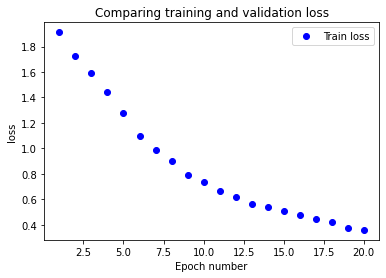

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Score for fold 1: loss of 4.2039794921875; recall of 26.04166567325592%; precision of 29.069766402244568%
------------------------------------------------------------------------
Training for fold 2 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_35 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_36 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 11

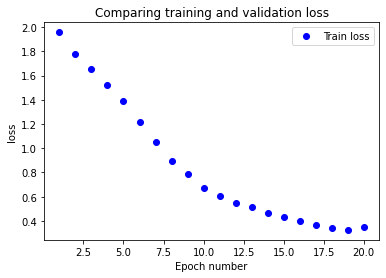

Score for fold 2: loss of 2.6768264770507812; recall of 31.874999403953552%; precision of 38.93129825592041%
------------------------------------------------------------------------
Training for fold 3 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_37 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_38 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None,

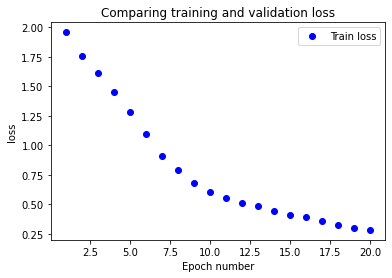

Score for fold 3: loss of 2.895061492919922; recall of 27.08333432674408%; precision of 32.098764181137085%
------------------------------------------------------------------------
Training for fold 4 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_39 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_40 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 

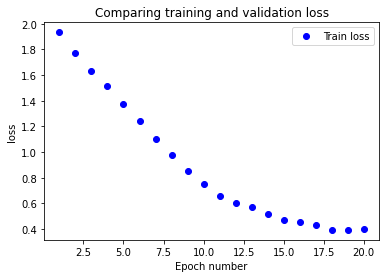

Score for fold 4: loss of 2.952929735183716; recall of 17.70833283662796%; precision of 21.794871985912323%
------------------------------------------------------------------------
Training for fold 5 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_41 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_42 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 

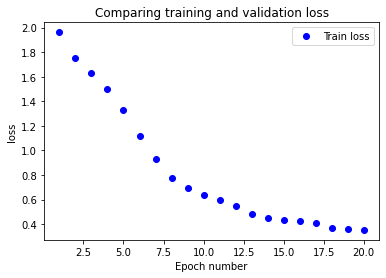

Score for fold 5: loss of 2.779662609100342; recall of 17.96875%; precision of 22.3300963640213%
------------------------------------------------------------------------
Training for fold 6 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_43 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_44 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 11, 2)     

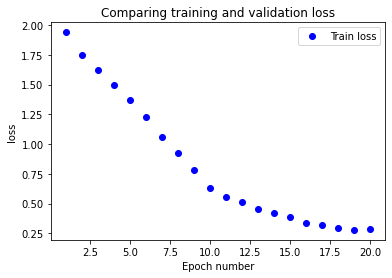

Score for fold 6: loss of 2.5129873752593994; recall of 31.25%; precision of 34.96503531932831%
------------------------------------------------------------------------
Training for fold 7 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_45 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_46 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 11, 2)      

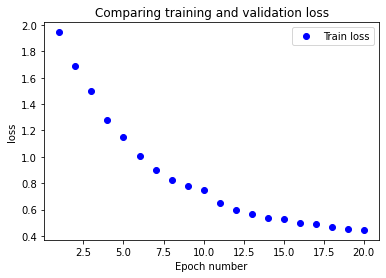

Score for fold 7: loss of 3.2402408123016357; recall of 22.499999403953552%; precision of 27.906978130340576%
------------------------------------------------------------------------
Training for fold 8 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_47 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_48 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None

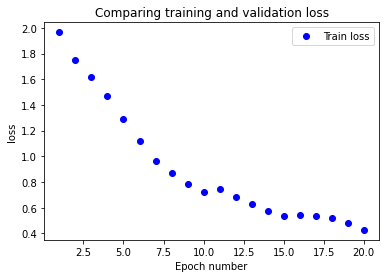

Score for fold 8: loss of 2.677022695541382; recall of 25.0%; precision of 33.33333432674408%
------------------------------------------------------------------------
Training for fold 9 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_49 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_50 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 11, 2)        

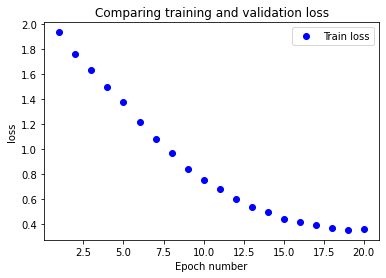

Score for fold 9: loss of 2.4550468921661377; recall of 28.125%; precision of 36.000001430511475%
------------------------------------------------------------------------
Training for fold 10 ...
training for params:  {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.001}
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 716, 8)            16392     
_________________________________________________________________
batch_normalization_51 (Batc (None, 716, 8)            32        
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 716, 2)            18        
_________________________________________________________________
batch_normalization_52 (Batc (None, 716, 2)            8         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 11, 2)   

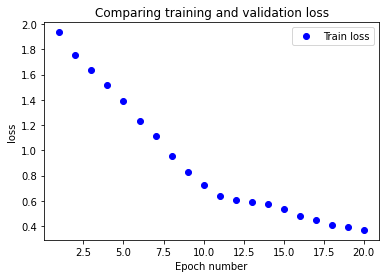

Score for fold 10: loss of 2.8554575443267822; recall of 17.70833283662796%; precision of 25.37313401699066%
------------------------------------------------------------------------
Precision and Recall per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.2039794921875 - Precision: 26.04166567325592 - Recall: 29.069766402244568 - F1: 27.472526455484083%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.6768264770507812 - Precision: 31.874999403953552 - Recall: 38.93129825592041 - F1: 35.05154625266732%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.895061492919922 - Precision: 27.08333432674408 - Recall: 32.098764181137085 - F1: 29.378531133947025%
------------------------------------------------------------------------
> Fold 4 - Loss: 2.952929735183716 - Precision: 17.70833283662796 - Recall: 21.794871985912323 - F1: 19.540229659443373%
--------------

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
param_grid = {
    "learn_rate": [0.001],
    "batch_size": [32],
    "epochs": [20]
}
grid = ParameterGrid(param_grid)
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for i, params in enumerate(grid):
    precision_per_fold, recall_per_fold, loss_per_fold = [], [], []
    for train, test in kfold.split(speakers):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        print("training for params: ", params)
        train_data_ids = dataset[dataset['speakers'].isin(speakers[train])].visual_features.reset_index()
        y_train_ids = dataset[dataset['speakers'].isin(speakers[train])].emotion_labels
        test_data_ids = dataset[dataset['speakers'].isin(speakers[test])].visual_features.reset_index()
        y_test_ids = dataset[dataset['speakers'].isin(speakers[test])].emotion_labels
        visual_model = visual_model_init(4, (716,2048), 'categorical_crossentropy', params["learn_rate"])
        training_generator = VisualDataGenerator(train_data_ids, y_train_ids, class_weights,
                                                 batch_size=params["batch_size"])
        test_generator = VisualDataGenerator(test_data_ids, y_test_ids, class_weights,
                                                 batch_size=params["batch_size"])
        results = visual_model.fit_generator(training_generator, epochs=params["epochs"], verbose=2,
                                           callbacks=[early_stop])
        eval_metric(results, 'loss')
        visual_model.save(base_path + '/checkpoints_visual/model_' + str(fold_no) + '.h5')
        scores = visual_model.evaluate_generator(test_generator)
        print(
            f'Score for fold {fold_no}: {visual_model.metrics_names[0]} of {scores[0]}; {visual_model.metrics_names[1]} of {scores[1] * 100}%; {visual_model.metrics_names[2]} of {scores[2] * 100}%')
        precision_per_fold.append(scores[1] * 100)
        recall_per_fold.append(scores[2] * 100)
        loss_per_fold.append(scores[0])

        fold_no = fold_no + 1
    print_average_score(precision_per_fold, recall_per_fold, loss_per_fold)

# Audio Modal

This is the audio data generator. Padded the data with zeros to make (24,128) dimensions.

In [ ]:
import numpy as np
import keras

class audioDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,class_weights, batch_size=32,
                 n_classes=4, shuffle=True,predict=False):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.class_weights = class_weights
        self.predict= predict
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs )/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

        # Generate data
        X, y, sample_weights = self.__data_generation(list_IDs_temp)
        if self.predict:
            return X,y,None
        return X, y, sample_weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dist = 24 - len(audio_data[ID[0]])
            # X.append(audio_data[ID[0]])
            X.append(np.pad(audio_data[ID[0]], pad_width=[(0,dist), (0,0)], mode='constant'))
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])

        return np.stack(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)

Audio model architecture

In [ ]:
def audio_model_init(hidden_units, input_shape, loss, lr):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(LSTM(16))
    model.add(Dense(4, activation="softmax", name="Dense_2"))
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    amsgrad=False,
                    name="Adam",
                )
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
    model.summary()
    return model    

------------------------------------------------------------------------
Training for fold 1 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37/37 - 2s - loss: 1.3865 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
37/37 - 0s - loss: 1.2866 - recall: 8.4459e-04 - precision: 1.0000
Epoch 3/80
37/37 - 0s - loss: 1.1897 - recall: 0.0870 - precision: 0.6398
Epoch 4/80
37/37 - 0s - loss: 1.1379 - recall: 0.1470 - precision: 0.6493
Epoch 5/80
37/37 - 0s - loss: 1.0608 - recall: 0.3657 - precision: 0.6862
Epoch 6/80
37/37 - 0s - loss: 0.9951 - recall: 0.5785 - precision: 0.6580
Epoch 7/80
37/37 - 0s - loss: 0.9508 - recall: 0.6132 - precision: 0.6888
Epoch 8/80
37/37 - 0s - loss: 0.9123 - recall: 0.6402 - precision: 0.7032
Epoch 9/80
37/37 - 0s - loss: 0.8791 - recall: 0.6723 - precision: 0.7243
Epoch 10/80
37/37 - 0s - loss: 0.8495 - recall: 0.6968 - precision: 0.7346
Epoch 11/80
37/37 - 0s - loss: 0.8166 - recall: 0.7145 - precision: 0.7421
Epoch 12/80
37/37 - 0s - loss: 0.8152 - recall: 0.7069 - precision: 0.7453
Epoch 13/80
37/37 - 0s - loss: 0.7881 - recall: 0.7297 - precision: 0.7592
Epoch 14/80
37/37 - 0s - loss: 0.

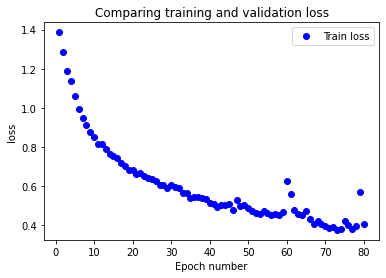

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Score for fold 1: loss of 1.748953938484192; recall of 51.04166865348816%; precision of 51.57894492149353%
------------------------------------------------------------------------
Training for fold 2 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
38/38 - 2s - loss: 1.3821 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
38/38 - 0s - loss: 1.3107 - recall: 0.0839 - precision: 0.4951
Epoch 3/80
38/38 - 0s - loss: 1.2026 - recall: 0.1488 - precision: 0.64

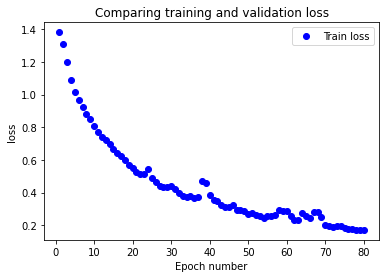

Score for fold 2: loss of 2.6208794116973877; recall of 40.625%; precision of 41.489362716674805%
------------------------------------------------------------------------
Training for fold 3 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
36/36 - 2s - loss: 1.3993 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
36/36 - 0s - loss: 1.3126 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 3/80
36/36 - 0s - loss: 1.1883 - recall: 0.1050 - precision: 0.668

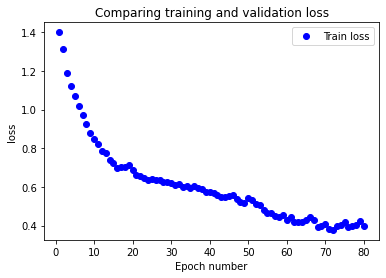

Score for fold 3: loss of 1.7565288543701172; recall of 51.249998807907104%; precision of 51.57232880592346%
------------------------------------------------------------------------
Training for fold 4 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
36/36 - 2s - loss: 1.3970 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
36/36 - 0s - loss: 1.3049 - recall: 0.0417 - precision: 0.7742
Epoch 3/80
36/36 - 0s - loss: 1.1512 - recall: 0.1415 - precision: 0.

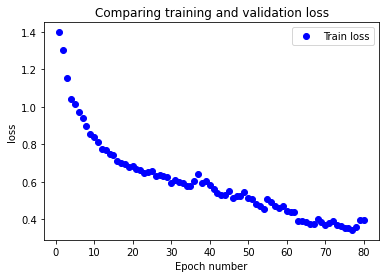

Score for fold 4: loss of 1.9896438121795654; recall of 44.999998807907104%; precision of 46.45161330699921%
------------------------------------------------------------------------
Training for fold 5 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
38/38 - 2s - loss: 1.3885 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
38/38 - 0s - loss: 1.2689 - recall: 0.0074 - precision: 0.6923
Epoch 3/80
38/38 - 0s - loss: 1.1345 - recall: 0.2336 - precision: 0.

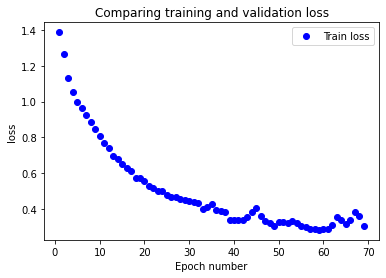

Score for fold 5: loss of 2.4948270320892334; recall of 40.625%; precision of 41.489362716674805%
------------------------------------------------------------------------
Training for fold 6 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
37/37 - 2s - loss: 1.3808 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
37/37 - 0s - loss: 1.2672 - recall: 0.0186 - precision: 0.7333
Epoch 3/80
37/37 - 0s - loss: 1.1407 - recall: 0.2230 - precision: 0.6519
Epoch 

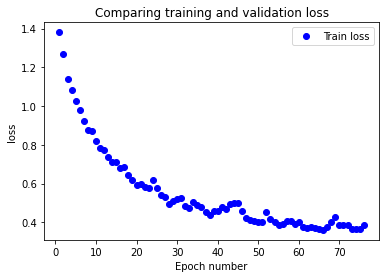

Score for fold 6: loss of 1.950792670249939; recall of 51.04166865348816%; precision of 51.57894492149353%
------------------------------------------------------------------------
Training for fold 7 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
37/37 - 2s - loss: 1.3888 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
37/37 - 0s - loss: 1.2433 - recall: 0.1157 - precision: 0.6062
Epoch 3/80
37/37 - 0s - loss: 1.1629 - recall: 0.1774 - precision: 0.64

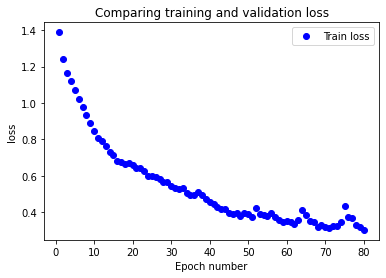

Score for fold 7: loss of 2.3992340564727783; recall of 37.5%; precision of 37.8947377204895%
------------------------------------------------------------------------
Training for fold 8 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
38/38 - 2s - loss: 1.3816 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
38/38 - 0s - loss: 1.2561 - recall: 0.1324 - precision: 0.5296
Epoch 3/80
38/38 - 0s - loss: 1.1192 - recall: 0.3059 - precision: 0.6503
Epoch 4/80

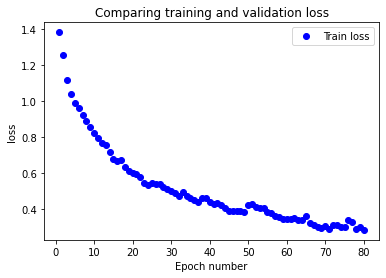

Score for fold 8: loss of 1.9924607276916504; recall of 52.08333134651184%; precision of 53.19148898124695%
------------------------------------------------------------------------
Training for fold 9 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
37/37 - 2s - loss: 1.3797 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
37/37 - 0s - loss: 1.2327 - recall: 0.0152 - precision: 0.7826
Epoch 3/80
37/37 - 0s - loss: 1.1354 - recall: 0.1546 - precision: 0.6

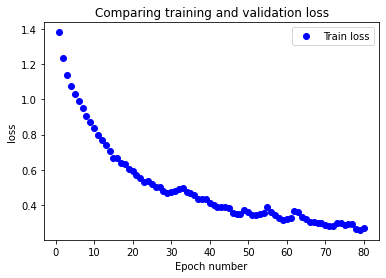

Score for fold 9: loss of 2.277622699737549; recall of 46.09375%; precision of 46.82539701461792%
------------------------------------------------------------------------
Training for fold 10 ...
Training for params:  {'batch_size': 32, 'epochs': 80, 'learn_rate': 0.001}
0.001
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 16)                9280      
_________________________________________________________________
Dense_2 (Dense)              (None, 4)                 68        
Total params: 9,348
Trainable params: 9,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
36/36 - 2s - loss: 1.3828 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/80
36/36 - 0s - loss: 1.2499 - recall: 0.0460 - precision: 0.7910
Epoch 3/80
36/36 - 0s - loss: 1.1403 - recall: 0.2205 - precision: 0.7095
Epoch

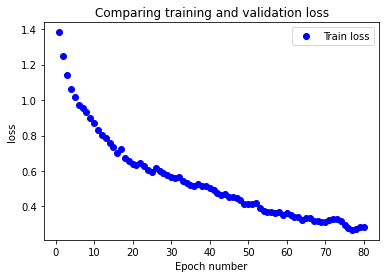

Score for fold 10: loss of 2.2497172355651855; recall of 39.375001192092896%; precision of 40.909090638160706%
------------------------------------------------------------------------
Precision and Recall per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.748953938484192 - Precision: 51.04166865348816 - Recall: 51.57894492149353 - F1: 51.308900316714144%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.6208794116973877 - Precision: 40.625 - Recall: 41.489362716674805 - F1: 41.0526320755977%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.7565288543701172 - Precision: 51.249998807907104 - Recall: 51.57232880592346 - F1: 51.410658582855326%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.9896438121795654 - Precision: 44.999998807907104 - Recall: 46.45161330699921 - F1: 45.714285294695436%
---------------------

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
param_grid = {
    "learn_rate": [0.001],
    "batch_size": [32],
    "epochs": [80]
}
grid = ParameterGrid(param_grid)
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for i, params in enumerate(grid):
    precision_per_fold, recall_per_fold, loss_per_fold = [], [], []
    for train, test in kfold.split(speakers):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        print("Training for params: ", params)
        train_data_ids = dataset[dataset['speakers'].isin(speakers[train])].acoustic_features.reset_index()
        y_train_ids = dataset[dataset['speakers'].isin(speakers[train])].emotion_labels

        test_data_ids = dataset[dataset['speakers'].isin(speakers[test])].acoustic_features.reset_index()
        y_test_ids = dataset[dataset['speakers'].isin(speakers[test])].emotion_labels
        
        print(params["learn_rate"])
        audio_model = audio_model_init(4, (24,128), 'categorical_crossentropy', params["learn_rate"])
        training_generator = audioDataGenerator(train_data_ids, y_train_ids, class_weights,
                                                 batch_size=params["batch_size"])
        test_generator = audioDataGenerator(test_data_ids, y_test_ids, class_weights,
                                                 batch_size=params["batch_size"])
        results = audio_model.fit_generator(training_generator, epochs=params["epochs"], verbose=2,callbacks=[early_stop])
        eval_metric(results, 'loss')
        audio_model.save(base_path + '/checkpoints_audio/model_' + str(fold_no) + '.h5')
        scores = audio_model.evaluate_generator(test_generator)
        print(
            f'Score for fold {fold_no}: {audio_model.metrics_names[0]} of {scores[0]}; {audio_model.metrics_names[1]} of {scores[1] * 100}%; {audio_model.metrics_names[2]} of {scores[2] * 100}%')
        precision_per_fold.append(scores[1] * 100)
        recall_per_fold.append(scores[2] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    print_average_score(precision_per_fold, recall_per_fold, loss_per_fold)

# Late fusion

In [ ]:
visual_model = keras.models.load_model('/content/drive/MyDrive/CSCI535/HW2/checkpoints_visual/model_2.h5')

In [ ]:
audio_model = keras.models.load_model('/content/drive/MyDrive/CSCI535/HW2/checkpoints_audio/model_8.h5')

In [ ]:
text_model = keras.models.load_model('/content/drive/MyDrive/CSCI535/HW2/checkpoints_text/model_2.h5')

In [ ]:
precision_per_fold, recall_per_fold = [], []
for train, test in kfold.split(speakers):
    test_data_ids_audio = dataset[dataset['speakers'].isin(speakers[test])].acoustic_features.reset_index()
    test_data_ids_text = dataset[dataset['speakers'].isin(speakers[test])].lexical_features.reset_index()
    test_data_ids_visual = dataset[dataset['speakers'].isin(speakers[test])].visual_features.reset_index()
    y_test_ids = dataset[dataset['speakers'].isin(speakers[test])].emotion_labels   
    vis_data = VisualDataGenerator(test_data_ids_visual,y_test_ids,class_weights,32,False,True)
    aud_data = audioDataGenerator(test_data_ids_visual,y_test_ids,class_weights,32,False,True)
    tex_data = DataGenerator(test_data_ids_visual,y_test_ids,class_weights,32,False,True)
    vis_probs = visual_model.predict_generator(vis_data)
    aud_probs = audio_model.predict_generator(aud_data)
    tex_probs = text_model.predict_generator(tex_data)
    total_pros = vis_probs+aud_probs+tex_probs
    y_pred = total_pros.argmax(axis=1)
    y_true = np.array(y_test_ids.tolist())[:len(y_pred)]
    precision_per_fold.append(sklearn.metrics.precision_score(y_true, y_pred,average="micro")* 100)
    recall_per_fold.append(sklearn.metrics.recall_score(y_true, y_pred,average="micro")* 100)
    print(sklearn.metrics.confusion_matrix(np.array(y_test_ids.tolist())[:len(y_pred)], total_pros.argmax(axis=1)))
    # df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(np.array(y_test_ids.tolist())[:len(y_pred)], total_pros.argmax(axis=1)))
    # df_cm.index.name = "Actual"
    # df_cm.columns.name = "Predicted"
    # sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("flare"))
print_average_score(precision_per_fold, recall_per_fold, None)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[ 5  5  2 12]
 [ 6  7  4 25]
 [ 2  5  0 13]
 [12 13  6 43]]
[[ 2  1  0  8]
 [ 5 16  2 13]
 [ 5  6  1  6]
 [ 4 11  3 13]]
[[22  4  3 15]
 [ 7  5  5  5]
 [ 6  2  2  8]
 [19  6  4 15]]
[[11 10  2 17]
 [12 11  4 17]
 [ 3  4  0  8]
 [10 17  5 29]]
[[12  4  2 18]
 [ 5  3  1 21]
 [ 2  5  1  9]
 [13 19  3 42]]
[[ 8  4  0 13]
 [ 5  3  3  8]
 [ 2  2  0  4]
 [13  3  3 25]]
[[23  4  5 17]
 [ 7  6  2  5]
 [ 3  2  1  2]
 [ 7  5  1  6]]
[[ 0  3  2  7]
 [ 2 11  6 16]
 [ 5  2  1  5]
 [ 5 12  3 16]]
[[ 3  1  2  7]
 [ 8  3  2  8]
 [ 5  4  4  8]
 [ 2  7  9 23]]
[[ 1  2  1  8]
 [ 1  1  2 11]
 [ 1  2  0  9]
 [ 4  7  3 43]]
------------------------------------------------------------------------
Precision and Recall per fold
------------------------------------------------------------------------
> Fold 1 - Precision: 34.375 - Recall: 34.375 - F1: 34.375%
------------------------------------------------------------------------
> Fold 2 - Precision: 33.33333333333333 - Recall: 33.33333333333333 - F1: 33.3333

# Early fusion

In [ ]:
def fusion_model_init(lr):
    audio_input = tf.keras.layers.Input(shape=(24,128), name="audio")
    video_input = tf.keras.layers.Input(shape=(716,2048), name="video")
    text_input = tf.keras.layers.Input(shape=(768,), name="text")
    dense1 = Dense(4, activation="relu", name="Dense_1")(audio_input)
    dense2 = Dense(4, activation="relu", name="Dense_2")(video_input)
    dense3 = Dense(4, activation="relu", name="Dense_3")(text_input)
    flatten_audio = tf.keras.layers.Flatten()(dense1)
    flatten = tf.keras.layers.Flatten()(dense2)
    flatten_text = tf.keras.layers.Flatten()(dense3)
    feature_inputs = tf.keras.layers.Concatenate()(
                [
                    flatten,
                    flatten_audio,
                    flatten_text,
                ]
            )

    dense = Dense(4, activation="relu", name="Dense_4")(feature_inputs)
    dense_out = Dense(4, activation="softmax", name="Dense_5")(dense)
    optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr,
                    amsgrad=False,
                    name="Adam",
                )
    model = tf.keras.Model(inputs=[audio_input, video_input, text_input], outputs=dense_out)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")])
    model.summary()
    return model

In [ ]:
import numpy as np
import keras

class allDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs_audio, list_IDs_text, list_IDs_visual, labels,class_weights, batch_size=32,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs_audio = list_IDs_audio
        self.list_IDs_text = list_IDs_text
        self.list_IDs_visual = list_IDs_visual
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.class_weights = class_weights

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs_audio)/ self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp_audio = [self.list_IDs_audio.iloc[k] for k in indexes]
        list_IDs_temp_text = [self.list_IDs_text.iloc[k] for k in indexes]
        list_IDs_temp_video = [self.list_IDs_visual.iloc[k] for k in indexes]
        # Generate data
        X_audio, y, sample_weights_audio = self.__data_generation_audio(list_IDs_temp_audio)
        X_visual, y, sample_weights_text_visual = self.__data_generation_visual(list_IDs_temp_text)
        X_text, y, sample_weights_text = self.__data_generation_text(list_IDs_temp_video)
        return [X_audio, X_visual, X_text],y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs_audio))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation_audio(self, list_IDs_temp_audio):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp_audio):
            # Store sample
            dist = 24 - len(audio_data[ID[0]])
            # X.append(audio_data[ID[0]])
            X.append(np.pad(audio_data[ID[0]], pad_width=[(0,dist), (0,0)], mode='constant'))
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])

        return np.stack(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)
    
    def __data_generation_visual(self, list_IDs_temp_video):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp_video):
            dist = 716 - len(visual_data[ID[0]])
            # Store sample
            # X.append(np.vstack((visual_data[ID[0]], np.zeros((716-visual_data[ID[0]].shape[0],2048)))))
            X.append(np.pad(visual_data[ID[0]], pad_width=[(0,dist), (0,0)], mode='constant'))
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])
        return np.stack(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)
    def __data_generation_text(self, list_IDs_temp_text):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []
        sample_weights = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp_text):
            # Store sample
            X.append(text_data[ID[0]])
            # Store class
            y.append(self.labels[ID[0]])
            sample_weights.append(class_weights[np.argmax(self.labels[ID[0]])])

        return np.stack(X), np.array(keras.utils.to_categorical(y, num_classes=self.n_classes)), np.array(sample_weights)
        


------------------------------------------------------------------------
Training for fold 1 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
__________________________________________________________________________________________________
Dense_2 (De

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
37/37 - 12s - loss: 1.3958 - recall: 0.0034 - precision: 0.1176
Epoch 2/15
37/37 - 11s - loss: 1.3063 - recall: 0.0017 - precision: 1.0000
Epoch 3/15
37/37 - 11s - loss: 1.2448 - recall: 0.0177 - precision: 0.6562
Epoch 4/15
37/37 - 11s - loss: 1.1583 - recall: 0.1225 - precision: 0.6744
Epoch 5/15
37/37 - 11s - loss: 1.0474 - recall: 0.2534 - precision: 0.6667
Epoch 6/15
37/37 - 11s - loss: 0.8919 - recall: 0.3176 - precision: 0.6494
Epoch 7/15
37/37 - 11s - loss: 0.6496 - recall: 0.5169 - precision: 0.7747
Epoch 8/15
37/37 - 11s - loss: 0.4489 - recall: 0.8226 - precision: 0.8838
Epoch 9/15
37/37 - 11s - loss: 0.3091 - recall: 0.9147 - precision: 0.9360
Epoch 10/15
37/37 - 11s - loss: 0.2268 - recall: 0.9426 - precision: 0.9490
Epoch 11/15
37/37 - 11s - loss: 0.1745 - recall: 0.9561 - precision: 0.9585
Epoch 12/15
37/37 - 11s - loss: 0.1443 - recall: 0.9620 - precision: 0.9628
Epoch 13/15
37/37 - 11s - loss: 0.1201 - recall: 0.9654 - precision: 0.9654
Epoch 14/15
37/37 - 1

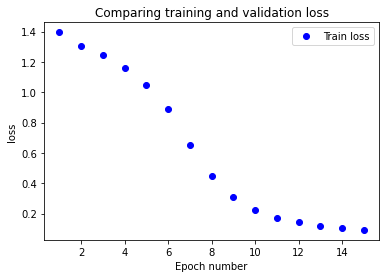

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Score for fold 1: loss of 1.273811936378479; recall of 57.29166865348816%; precision of 61.7977499961853%
------------------------------------------------------------------------
Training for fold 2 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
____

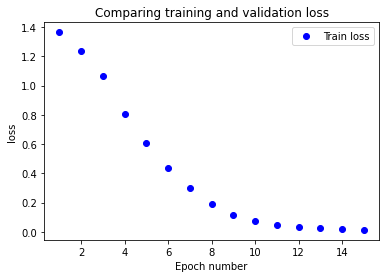

Score for fold 2: loss of 2.2123355865478516; recall of 34.375%; precision of 36.666667461395264%
------------------------------------------------------------------------
Training for fold 3 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
____________

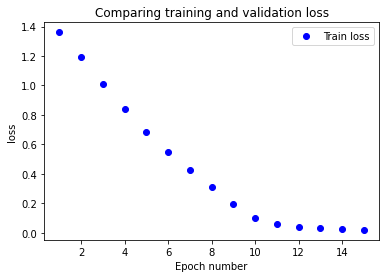

Score for fold 3: loss of 2.0406153202056885; recall of 46.875%; precision of 53.19148898124695%
------------------------------------------------------------------------
Training for fold 4 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
_____________

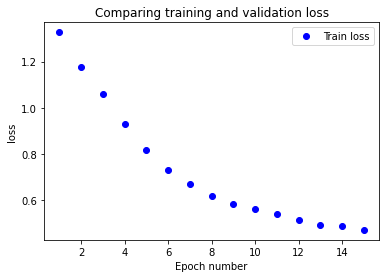

Score for fold 4: loss of 1.90041983127594; recall of 32.29166567325592%; precision of 44.92753744125366%
------------------------------------------------------------------------
Training for fold 5 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
____

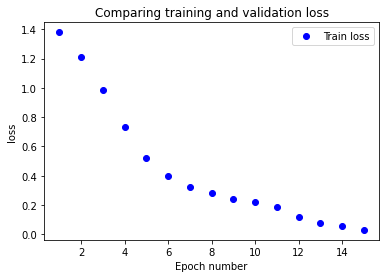

Score for fold 5: loss of 1.982061743736267; recall of 51.249998807907104%; precision of 56.94444179534912%
------------------------------------------------------------------------
Training for fold 6 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
__

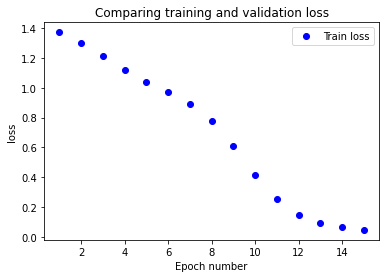

Score for fold 6: loss of 2.4848673343658447; recall of 50.0%; precision of 53.33333611488342%
------------------------------------------------------------------------
Training for fold 7 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
_______________

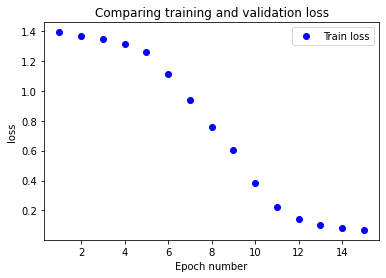

Score for fold 7: loss of 2.45768141746521; recall of 39.58333432674408%; precision of 41.75824224948883%
------------------------------------------------------------------------
Training for fold 8 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
____

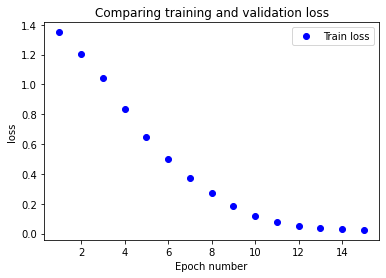

Score for fold 8: loss of 2.3477320671081543; recall of 39.84375%; precision of 42.85714328289032%
------------------------------------------------------------------------
Training for fold 9 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            
___________

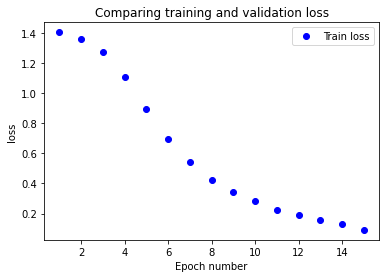

Score for fold 9: loss of 3.3257458209991455; recall of 27.500000596046448%; precision of 30.136987566947937%
------------------------------------------------------------------------
Training for fold 10 ...
Training for params:  {'batch_size': 32, 'epochs': 15, 'learn_rate': 0.001}
0.001
Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video (InputLayer)              [(None, 716, 2048)]  0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, 24, 128)]    0                                            
__________________________________________________________________________________________________
text (InputLayer)               [(None, 768)]        0                                            

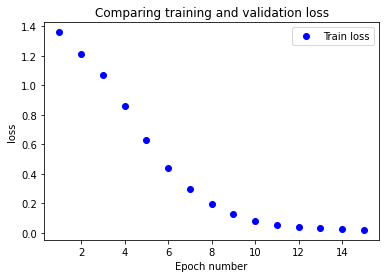

Score for fold 10: loss of 2.3619730472564697; recall of 47.91666567325592%; precision of 48.93617033958435%
------------------------------------------------------------------------
Precision and Recall per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.273811936378479 - Precision: 57.29166865348816 - Recall: 61.7977499961853 - F1: 59.45945922748453%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.2123355865478516 - Precision: 34.375 - Recall: 36.666667461395264 - F1: 35.483871339883315%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.0406153202056885 - Precision: 46.875 - Recall: 53.19148898124695 - F1: 49.83388687621926%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.90041983127594 - Precision: 32.29166567325592 - Recall: 44.92753744125366 - F1: 37.57575732617336%
----------------------------------------

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
param_grid = {
    "learn_rate": [0.001],
    "batch_size": [32],
    "epochs": [15]
}
grid = ParameterGrid(param_grid)
kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1
for i, params in enumerate(grid):
    precision_per_fold, recall_per_fold, loss_per_fold = [], [], []
    for train, test in kfold.split(speakers):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        print("Training for params: ", params)

        train_data_ids_audio = dataset[dataset['speakers'].isin(speakers[train])].acoustic_features.reset_index()
        train_data_ids_text = dataset[dataset['speakers'].isin(speakers[train])].lexical_features.reset_index()
        train_data_ids_visual = dataset[dataset['speakers'].isin(speakers[train])].visual_features.reset_index()
        
        y_train_ids = dataset[dataset['speakers'].isin(speakers[train])].emotion_labels

        test_data_ids_audio = dataset[dataset['speakers'].isin(speakers[test])].acoustic_features.reset_index()
        test_data_ids_text = dataset[dataset['speakers'].isin(speakers[test])].lexical_features.reset_index()
        test_data_ids_visual = dataset[dataset['speakers'].isin(speakers[test])].visual_features.reset_index()
        y_test_ids = dataset[dataset['speakers'].isin(speakers[test])].emotion_labels
        
        print(params["learn_rate"])
        fusion_model = fusion_model_init(lr=params["learn_rate"])
        training_generator = allDataGenerator(train_data_ids_audio,train_data_ids_text,train_data_ids_visual, y_train_ids, class_weights,
                                                 batch_size=params["batch_size"])
        test_generator = allDataGenerator(test_data_ids_audio,test_data_ids_text,test_data_ids_visual, y_test_ids, class_weights,
                                                 batch_size=params["batch_size"])
        results = fusion_model.fit_generator(training_generator, epochs=params["epochs"], verbose=2,callbacks=[early_stop])
        eval_metric(results, 'loss')
        fusion_model.save(base_path + '/checkpoints_fusion/model_' + str(fold_no) + '.h5')
        scores = fusion_model.evaluate_generator(test_generator)
        print(
            f'Score for fold {fold_no}: {fusion_model.metrics_names[0]} of {scores[0]}; {fusion_model.metrics_names[1]} of {scores[1] * 100}%; {fusion_model.metrics_names[2]} of {scores[2] * 100}%')
        precision_per_fold.append(scores[1] * 100)
        recall_per_fold.append(scores[2] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    print_average_score(precision_per_fold, recall_per_fold, loss_per_fold)

# Conclusion

As expected, looks like trimodal model is perrforming better than unimodal models. But intersetengly in my experiments, text has consitantly shown better results than all other experiments. Second best is the audio modality but visual modality does not perform that well.


**Early fusion and Late fusion**

Early fusion works much better than late fusion. This might be because in early fusion each training exampkle is fed with all three modalities at once. Hence it is able to predict better.